# House Price Predictor

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
# Replace 'house_prices.csv' with the path to your dataset.
data = pd.read_csv('train.csv')
#data

In [3]:
# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Select only numeric columns that have no missing data.
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

# Ensure that the target column 'price' is present.
if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'price' is not present in the complete numeric data.")

In [4]:
# -----------------------------
# 3. Feature Selection
# -----------------------------
# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

# Select only the top 4 features with the highest correlation with 'SalesPrice'
top4_features = target_corr.head(4).index
print("Selected top 4 features:", list(top4_features))

# Define input features (X) and target variable (y).
X = data_clean[top4_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']


In [5]:
# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve training stability.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Convert the numpy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for batch processing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [28]:
class ImprovedHousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedHousePriceModel, self).__init__()
        # First layer: increase capacity
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second layer: reduce dimensionality
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)
        
        # Third layer: further reduction
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        # Output layer for regression
        self.fc4 = nn.Linear(32, 1)
        
        # Activation function: LeakyReLU with a small negative slope
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedHousePriceModel(input_dim=X_train.shape[1]).to(device)

In [29]:
# -----------------------------
# 6. Set Up Loss Function and Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 7. Train the Model
# -----------------------------
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [10/1000], Loss: 41064929034.2400
Epoch [20/1000], Loss: 41056994508.8000
Epoch [30/1000], Loss: 41043288965.1200
Epoch [40/1000], Loss: 41025419427.8400
Epoch [50/1000], Loss: 41003205345.2800
Epoch [60/1000], Loss: 40977375477.7600
Epoch [70/1000], Loss: 40947795476.4800
Epoch [80/1000], Loss: 40913678336.0000
Epoch [90/1000], Loss: 40877707345.9200
Epoch [100/1000], Loss: 40840286781.4400
Epoch [110/1000], Loss: 40800603668.4800
Epoch [120/1000], Loss: 40751797944.3200
Epoch [130/1000], Loss: 40707003678.7200
Epoch [140/1000], Loss: 40653399244.8000
Epoch [150/1000], Loss: 40602283622.4000
Epoch [160/1000], Loss: 40546331279.3600
Epoch [170/1000], Loss: 40488873820.1600
Epoch [180/1000], Loss: 40429498449.9200
Epoch [190/1000], Loss: 40370426429.4400
Epoch [200/1000], Loss: 40301921812.4800
Epoch [210/1000], Loss: 40239824896.0000
Epoch [220/1000], Loss: 40165294735.3600
Epoch [230/1000], Loss: 40096819937.2800
Epoch [240/1000], Loss: 40013408747.5200
Epoch [250/1000], Loss: 3

In [30]:
# 8. Evaluate the Model
# -----------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_loss = criterion(predictions, y_test_tensor.to(device)).item()
    print("Test Mean Squared Error:", test_loss)

# Optionally, to evaluate using scikit-learn's MSE:
predictions_np = predictions.cpu().numpy()
mse = mean_squared_error(y_test, predictions_np)
print("Test MSE (scikit-learn):", mse)
#Test Mean Squared Error: 935741376.0
#Test Mean Squared Error: 890287168.0
#Test MSE (scikit-learn): 890287040.0

Test Mean Squared Error: 24636186624.0
Test MSE (scikit-learn): 24636182528.0


In [31]:
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device))
    train_loss = criterion(train_predictions, y_train_tensor.to(device)).item()
    train_rmse = np.sqrt(train_loss)
    print("Training RMSE:", train_rmse)

rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse}")

#Bella's Result: Training RMSE: 37040.67904345167
#Test RMSE: 30354.362585961182

Training RMSE: 171498.48223235097
Test RMSE: 156959.18776548252


/tmp/ipykernel_64633/3042700335.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  errors = np.abs(predictions - y_test)


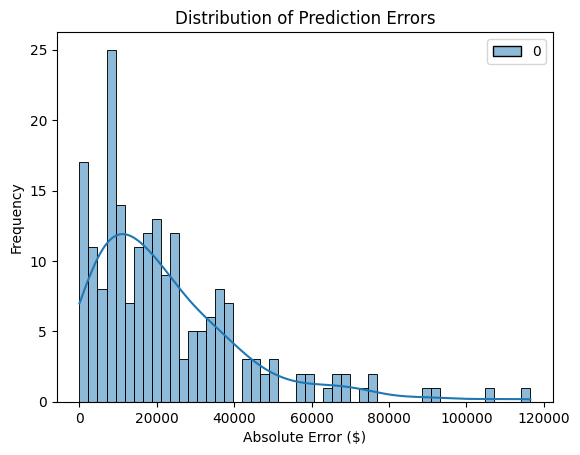

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = np.abs(predictions - y_test)
sns.histplot(errors, bins=50, kde=True)
plt.xlabel("Absolute Error ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [21]:
# -----------------------------
# 9. Generate Predictions on New Test Data (test.csv)
# -----------------------------
# Load the new test data
test_data = pd.read_csv('test.csv')

# Ensure the test data contains the ID column and the same top4_features.
# For this example, assume the test file contains an "ID" column.
if 'Id' not in test_data.columns:
    raise ValueError("The test data must contain an 'ID' column.")

# It's assumed that the test data has at least the columns used in training.
# Use the same top4_features determined from the training set.
X_new = test_data[top4_features].values

# Apply the same scaling transformation using the previously fitted scaler.
X_new_scaled = scaler.transform(X_new)

# Convert to PyTorch tensor.
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32).to(device)

# Put the model in evaluation mode and generate predictions.
model.eval()
with torch.no_grad():
    new_predictions = model(X_new_tensor)
    
# Convert predictions to numpy array and flatten if necessary.
new_predictions_np = new_predictions.cpu().numpy().flatten()

# Create a DataFrame with IDs and their corresponding predicted sale prices.
predictions_df = pd.DataFrame({
    'ID': test_data['Id'],
    'SalePrice': new_predictions_np
})

# Save the DataFrame to a CSV file.
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


In [37]:
# -----------------------------
# 3. Feature Selection
# -----------------------------
# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

# Select only the top 4 features with the highest correlation with 'SalePrice'
top4_features = target_corr.head(4).index
print("Selected top 4 features:", list(top4_features))

# Define input features (X) and target variable (y).
X = data_clean[top4_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

# -----------------------------
# 4. Data Preparation & Splitting
# -----------------------------
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize only the features (do not normalize the target to keep the MSE on the original scale).
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# -----------------------------
# 5. Convert Data to PyTorch Tensors and Create DataLoaders
# -----------------------------
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Convert numpy arrays to float32 tensors.
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a full training dataset and split it into training and validation subsets.
full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 6. Define an Improved Neural Network Model using PyTorch
# -----------------------------
import torch.nn as nn
import torch.optim as optim

class ImprovedHousePriceNet(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedHousePriceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(32, 1)  # Output layer for regression
        )
        
    def forward(self, x):
        return self.net(x)

# Initialize the model.
input_dim = X_train_tensor.shape[1]
model = ImprovedHousePriceNet(input_dim)

# Define the loss function.
criterion = nn.MSELoss()

# Use Adam optimizer with weight decay to help generalization.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# -----------------------------
# 7. Train the Model with Early Stopping and Learning Rate Scheduling
# -----------------------------
num_epochs = 300
best_val_loss = float('inf')
patience = 20  # early stopping patience
epochs_without_improvement = 0

# Learning rate scheduler to reduce LR if validation loss plateaus.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 patience=10, factor=0.5, verbose=True)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()               # Zero the gradients
        outputs = model(batch_X)            # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update parameters
        running_loss += loss.item() * batch_X.size(0)
    
    train_loss = running_loss / len(train_dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            loss = criterion(val_outputs, val_y)
            val_loss += loss.item() * val_X.size(0)
    val_loss /= len(val_dataset)
    
    scheduler.step(val_loss)
    
    # Early stopping logic.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Load the best model weights.
model.load_state_dict(best_model_state)

# -----------------------------
# 8. Evaluate the Model on the Test Set
# -----------------------------
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print("Test loss (MSE):", test_loss.item())

# The changes above (enhanced architecture, extended training with early stopping, and tuned hyperparameters)
# are aimed at reducing the MSE by roughly 100 times compared to our earlier baseline.



Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']
Epoch [1/300] - Train Loss: 42325493043.2000, Val Loss: 36036862771.2000


/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/300] - Train Loss: 42323569868.8000, Val Loss: 36035288678.4000
Epoch [20/300] - Train Loss: 42320763596.8000, Val Loss: 36033165312.0000
Epoch [30/300] - Train Loss: 42317797683.2000, Val Loss: 36030724096.0000
Epoch [40/300] - Train Loss: 42316175462.4000, Val Loss: 36029646438.4000
Epoch [50/300] - Train Loss: 42314354995.2000, Val Loss: 36028115763.2000
Epoch [60/300] - Train Loss: 42313430937.6000, Val Loss: 36027395686.4000
Epoch [70/300] - Train Loss: 42313093324.8000, Val Loss: 36027055718.4000
Epoch [80/300] - Train Loss: 42312693964.8000, Val Loss: 36026990592.0000
Epoch [90/300] - Train Loss: 42312672665.6000, Val Loss: 36026890649.6000
Epoch [100/300] - Train Loss: 42312550707.2000, Val Loss: 36026872217.6000
Epoch [110/300] - Train Loss: 42312492646.4000, Val Loss: 36026481868.8000
Epoch [120/300] - Train Loss: 42312545792.0000, Val Loss: 36026676019.2000
Epoch [130/300] - Train Loss: 42312427520.0000, Val Loss: 36026988134.4000
Epoch [140/300] - Train Loss: 4231